In [417]:
# Graph neural network where edge weights are distances between FC matrices

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [433]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [434]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [435]:
# Calculare pearson matrices

train_p = [np.corrcoef(sub) for sub in train_rest_ts]
test_p = [np.corrcoef(sub) for sub in test_rest_ts]

print('Complete')

Complete


In [436]:
# Create feature vectors (right now just ages)

X_train = []
for subj in train:
    feat = np.array([subj['meta']['AgeInMonths']])
    X_train.append(feat)
    
X_test = []
for subj in test:
    feat = np.array([subj['meta']['AgeInMonths']])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print('Complete')

Complete


In [437]:
# Calculate edge weights
import math

def calc_e(p):
    N = len(p)
    e = np.zeros([N,N])
    print('Done', end=' ')
    for i in range(N):
        print(i, end=' ')
        e[i,i] = 0
        for j in range(i+1,N):
            d = np.linalg.norm(p[i]-p[j])
            e[i,j] = d
            e[j,i] = d
            
    print('Finished!')
    return e

train_e = calc_e(train_p)
# test_e = calc_e(test_p)

Done 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 2

In [286]:
print(np.max(train_e))

154.4892297915354


In [459]:
# Find the adjacency matrix

# import scipy.linalg
import math

# Find the degree matrix
# def degree(A):
#     return np.sum(A,axis=0)
#     d[np.where(d==0)] = 1e-7 # Avoid singularity
#     return np.diag(d)

# def normalizedA(A):
#     D = degree(A)
#     invSqrtD = np.linalg.inv(scipy.linalg.sqrtm(D))
#     return invSqrtD@A@invSqrtD
    
def normalizedA(A):
    d = np.sum(A,axis=0)
    d[d == 0] = 1e-5
    d1 = d**0.5
    return ((A/d1).T/d1).T

def binarize(A, pctGone):
    N = A.shape[0]
    A = A.reshape([N*N])
    idcs = np.argsort(A)
    start = math.ceil(pctGone*len(idcs))
    Abin = np.zeros([N*N])
    Abin[idcs[start:]] = A[idcs[start:]]
    Abin = Abin.reshape([N,N])
    return Abin

train_e1 = train_e / np.max(train_e)
train_e1 = 1 - train_e1
train_e1 -= np.eye(train_e1.shape[0])

degree_e1 = np.sum(train_e1,axis=0)
# train_e1 = binarize(train_e1, 0.8)
train_e1 = normalizedA(train_e1)

# Make a dummy row/col
# train_e1 = np.vstack([train_e1, np.zeros([1,train_e1.shape[0]])])
# train_e1 = np.hstack([train_e1, np.zeros([train_e1.shape[0],1])])

print(train_e1.shape)
print('Complete')

(466, 466)
Complete


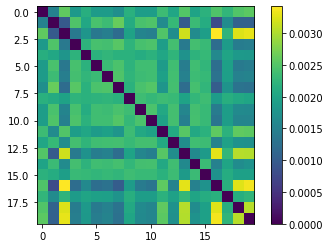

98.50541901041798
98.50541901041798


In [460]:
plt.imshow(train_e1[0:20,0:20])
plt.colorbar()
plt.show()

a,b = np.where(train_e1 > 0)
print(train_e[a[0],b[0]])
print(train_e[0,1])

In [463]:
# Get test ages

X_ages_test = np.ones([len(test_p),7])

for i in range(len(test_p)):
    # Calculate distances
    ds = np.zeros([len(train_p),1])
    dsp1 = np.zeros([1,len(train_p)+1])
    
    for j in range(len(train_p)):
        ds[j,0] = np.linalg.norm(test_p[i]-train_p[j]) 
        dsp1[0,j] = ds[j,0]
         
    train_e1 = np.hstack([train_e, ds])
    train_e1 = np.vstack([train_e1, dsp1])
    
    train_e1 = train_e1 / np.max(train_e1)
    train_e1 = 1 - train_e1
    train_e1 -= np.eye(train_e1.shape[0])
    
#     train_e1 = binarize(train_e1, 0.8)
    train_e1 = normalizedA(train_e1)
    
    # Find diffusion ages
    Xt = np.vstack([X_train, 0])
    a = Xt
    for j in range(X_ages.shape[1]-1):
        a = train_e1@a
        X_ages_test[i,j] = a[-1]
    
    print(i, end=' ')

print('Complete')
print(X_ages_test[-1,:])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 Complete
[179.47763756 179.67932079 179.72797991 179.73445603 179.73535403
 179.7354786    1.        ]


In [391]:
# X_ages_test[:,6] = 0
print(X_ages_test[-10,:])

[176.5647097  174.64429341 174.48688434 174.46743524 174.46504882
 174.46475587   1.        ]


In [392]:
print(X_ages_test[10,:])

[181.32857767 180.07012777 179.98924149 179.97929843 179.97808417
 179.97793571   1.        ]


(467, 467)
0.0023713149297889483


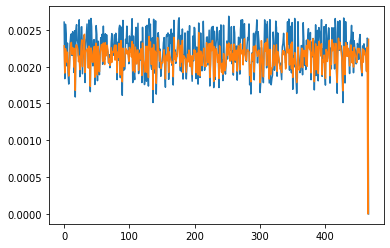

In [393]:
import matplotlib.pyplot as plt

print(train_e1.shape)
print(train_e1[-2,-1])

plt.plot(train_e1[-1,:])
plt.plot(train_e1[-2,:])
plt.show()

In [461]:
# Not a neural network!

# For each subject: zero out their age feature and calculate their age scores
# for various multiples of the adjacency matrix

X_ages = np.ones([X_train.shape[0],7])

for i in range(X_train.shape[0]):
    ageSav = X_train[i,0]
    X_train[i,0] = 0
    a = X_train
    for j in range(X_ages.shape[1]-1):
        a = train_e1@a
        X_ages[i,j] = a[i]
    X_train[i,0] = ageSav
    
print(X_ages[-3,:])

[178.44208054 177.01306544 176.87461553 176.85514968 176.85244445
 176.85206846   1.        ]


In [134]:
# Try 3rd order poly

def make3rdOrderPoly(ps):
    fi = np.vstack([p.flatten() for p in ps])
    se = fi**2
    th = fi**3
    return np.hstack([fi, se, th])

print('Complete')

Complete


In [462]:
# Regress on just the ages from the matrix

Xtrain = X_ages#[0:-1,:]
yTrain = X_train.flatten()#[0:-1,0]#.flatten()

# Xtrain = np.hstack([Xtrain, np.vstack([p.flatten() for p in train_p])])
Xtrain = make3rdOrderPoly(train_p)
Xtrain = np.hstack([X_ages, Xtrain])
print('Done pearson')

# w, r, _, _ = np.linalg.lstsq(Xtrain.T@Xtrain + 0.05*np.eye(Xtrain.shape[1]), Xtrain.T@yTrain, rcond=None)
w, r, _, _ = np.linalg.lstsq(Xtrain, yTrain, rcond=None)

print(r)
print('Complete')

Done pearson
[]
Complete


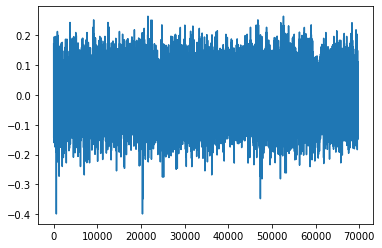

In [95]:
plt.plot(w)
plt.show()

Done pearson
[[1.         0.76111348]
 [0.76111348 1.        ]]
1.958325268806082
1.5637339521717557


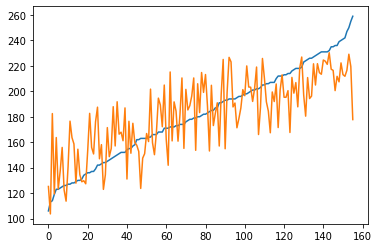

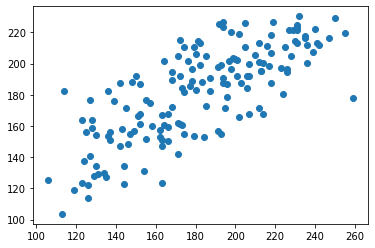

In [464]:
import matplotlib.pyplot as plt

# y = X_train.flatten()#[0:-1,0]#.flatten()

# # Xtrain = np.hstack([Xtrain, np.vstack([p.flatten() for p in train_p])])
# X = make3rdOrderPoly(train_p)
# X = np.hstack([X_ages, X])
# print('Done pearson')

# yPred = X@w

y = X_test.flatten()

# X = np.hstack([X, np.vstack([p.flatten() for p in test_p])])
X = make3rdOrderPoly(test_p)
X = np.hstack([X_ages_test, X])
print('Done pearson')

yPred = X@w

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [266]:
print(w[0:10])

[0.17676137 0.17400031 0.17752534 0.17794788 0.17799984 0.17800622
 0.01505743 0.01505743 0.0020556  0.00142561]


[[1.        0.4123423]
 [0.4123423 1.       ]]
3.096633534427779
2.596423462088698


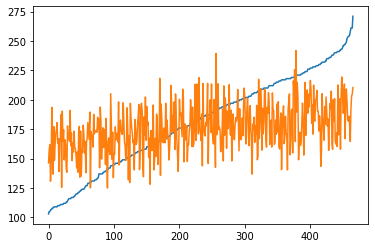

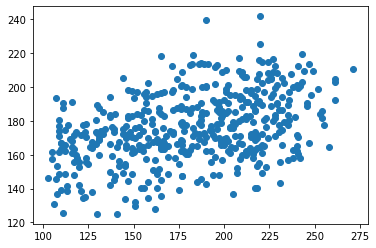

In [357]:
# KNN
# Take average ages of K nearest neighbors

k = 5
yPred = np.zeros(X_train.shape[0])
y = X_train.flatten()

for i in range(len(train_p)):
    row = train_e[i,:]
    idcs = np.argsort(row)[1:k+1]
    ages = X_train[idcs,0]
    pred = sum(ages)/len(ages)
    yPred[i] = pred
    
idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]
    
corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()